In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from torch.autograd import Function
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from PIL import Image
import pickle
from tqdm.notebook import tqdm
import random

In [2]:
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x

    @staticmethod
    def backward(ctx, grad_output):
        output =  - ctx.alpha * grad_output

        return output, None

In [64]:
class Downsample(nn.Module):
    def __init__(self):
        super(Downsample,self).__init__()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()
        
    
    def forward(self,x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.relu(self.bn2(self.conv2(x1)))
        
        x3 = self.pool1(x2)
        x4 = self.relu(self.bn3(self.conv3(x3)))
        x5 = self.relu(self.bn4(self.conv4(x4)))
        
        x6 = self.pool1(x5)
        x7 = self.relu(self.bn5(self.conv5(x6)))
        x8 = self.relu(self.bn6(self.conv6(x7)))
        
        x9 = self.pool1(x8)
        x10 = self.relu(self.bn7(self.conv7(x9)))
        x11 = self.relu(self.bn8(self.conv8(x10)))
        
        return x2,x5,x8,x11
    

class Upsample(nn.Module):
    def __init__(self):
        super(Upsample,self).__init__()
        
        self.deconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.conv13 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm2d(256)
        self.conv14 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.bn14 = nn.BatchNorm2d(256)
        
        self.deconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.conv15 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.bn15 = nn.BatchNorm2d(128)
        self.conv16 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.bn16 = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.conv17 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.bn17 = nn.BatchNorm2d(64)
        self.conv18 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.bn18 = nn.BatchNorm2d(64)
        
        self.conv19 = nn.Conv2d(64,1,kernel_size=1)
            
        self.relu = nn.ReLU()
        self.classifier = nn.Sigmoid()
    
    
    def _merge(self,layer_down,layer_up):
        slice_f = layer_up.size()[-1]//2
        center = layer_down.size()[-1]//2
        s,e = center-slice_f,center+slice_f
        x_out = torch.cat((layer_down[:,:,s:e,s:e],(layer_up)),1)
        
        return x_out
        
    
    def forward(self,x,x2,x5,x8):
        x19 = self.deconv2(x)  
        x20 = self._merge(x19,x8)
        
        x21 = self.relu(self.bn13(self.conv13(x20)))
        x22 = self.relu(self.bn14(self.conv14(x21)))
        
        x23 = self.deconv3(x22)      
        x24 = self._merge(x23,x5)
        
        
        x25 = self.relu(self.bn15(self.conv15(x24)))
        x26 = self.relu(self.bn16(self.conv16(x25)))
        
        x27 = self.deconv4(x26) 
        x28 = self._merge(x27,x2)
        
        x29 = self.relu(self.bn17(self.conv17(x28)))
        x30 = self.relu(self.bn18(self.conv18(x29)))
        x31 = self.classifier(self.conv19(x30))
        
        return x31


class Adaptation(nn.Module):
    def __init__(self):
        super(Adaptation,self).__init__()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv_ad1 = nn.Conv2d(512,512,kernel_size=3)
        self.bn_ad1 = nn.BatchNorm2d(512)
        
        self.conv_ad2 = nn.Conv2d(512,256,kernel_size=3)
        self.bn_ad2 = nn.BatchNorm2d(256)
        
        self.conv_ad3 = nn.Conv2d(256,256,kernel_size=3)
        self.bn_ad3 = nn.BatchNorm2d(256)
        
        self.conv_ad4 = nn.Conv2d(256,1024,kernel_size=3,padding=1)
        self.bn_ad4 = nn.BatchNorm2d(1024)
        
        self.conv_ad5 = nn.Conv2d(1024,1,kernel_size=1)
        self.bn_ad5 = nn.BatchNorm2d(1)
        
        self.classifier = nn.Sigmoid()
        self.relu = nn.ReLU()

    
    def forward(self,x,grl_lambda=1):
        x_ad0 = GradientReversalFn.apply(x,grl_lambda)
        x_ad1 = self.pool1(self.relu(self.bn_ad1(self.conv_ad1(x_ad0))))
        x_ad2 = self.pool1(self.relu(self.bn_ad2(self.conv_ad2(x_ad1))))
        x_ad3 = self.pool1(self.relu(self.bn_ad3(self.conv_ad3(x_ad2))))
        x_ad4 = self.pool1(self.relu(self.bn_ad4(self.conv_ad4(x_ad3))))
        x_ad5 = self.classifier((self.conv_ad5(x_ad4)))
        
        return x_ad5


class CountEstimate(nn.Module):
    def __init__(self):
        super(CountEstimate,self).__init__()
        
        self.downsample = Downsample()
        self.upsample = Upsample()
        self.adapt = Adaptation()
        
    def forward(self,x,grl_lambda=1):
        x2,x5,x8,x11 = self.downsample(x)
        x2 = self.upsample(x11,x2,x5,x8)
        x3 = self.adapt(x11)
        
        return x2,x3
       

In [65]:
def get_keys_from_pickle_dict(pkl_path):
    with open(pkl_path,'rb') as fp:
        d = pickle.load(fp)
    
    return list(d.keys())

In [66]:
class DomainAdaptationData(Dataset):
    def __init__(self,data_pkl,ds_order=None,transform=None,is_source=True):
        self.data_pkl = data_pkl
        self.transform = transform
        self.ds_order = ds_order
        self.is_source = is_source
        
        with open(self.data_pkl,'rb') as fp:
            self.data = pickle.load(fp)    
        
        if self.ds_order == None:
            self.ds_order = list(self.data.keys())
         
        
    def __len__(self):
        return len(self.ds_order)
    
    def __getitem__(self,index):
        cur_data_id = self.ds_order[index]
        
        if self.is_source:
            x,y = self.data[cur_data_id]
        else:
            x,y = self.data[cur_data_id],0
        
        if self.transform != None:
            x = self.transform(Image.fromarray((x*255).astype(np.uint8)))
        
        return x, torch.Tensor(y).unsqueeze(0), torch.tensor(self.is_source,dtype=torch.float32)

## Dataset 

In [67]:
SOURCE_DATA = 'acid_dataset.pkl'
TARGET_DATA = 'cq_wheat_2016_patches.pkl'

In [68]:
SOURCE_TRAIN_SIZE = 0.8
TARGET_TRAIN_SIZE = 1
TRAINING_BATCH = 16

In [69]:
transf = transforms.Compose([transforms.ToTensor()])

In [70]:
source_data_keys = get_keys_from_pickle_dict(SOURCE_DATA)
target_data_keys = get_keys_from_pickle_dict(TARGET_DATA)

In [71]:
source_ds_size = len(source_data_keys)
target_ds_size = len(target_data_keys)

source_train_keys,source_valid_keys = source_data_keys[:int(source_ds_size*SOURCE_TRAIN_SIZE)],source_data_keys[int(source_ds_size*SOURCE_TRAIN_SIZE):]
target_train_keys,target_valid_keys = target_data_keys[:int(target_ds_size*TARGET_TRAIN_SIZE)],target_data_keys[int(target_ds_size*TARGET_TRAIN_SIZE):]

In [72]:
train_source_ds = DomainAdaptationData(SOURCE_DATA,ds_order=source_train_keys,transform=transf)
valid_source_ds = DomainAdaptationData(SOURCE_DATA,ds_order=source_valid_keys,transform=transf)

train_target_ds = DomainAdaptationData(TARGET_DATA,ds_order=target_train_keys,is_source=False, transform=transf)

In [73]:
train_source_ds_loader = DataLoader(train_source_ds,batch_size=TRAINING_BATCH,drop_last=True,shuffle=False)
valid_source_ds_loader = DataLoader(valid_source_ds,batch_size=TRAINING_BATCH,drop_last=True,shuffle=False)

train_target_ds_loader = DataLoader(train_target_ds,batch_size=TRAINING_BATCH,drop_last=True,shuffle=False)

In [74]:
len(source_train_keys),len(target_train_keys),len(source_valid_keys),len(target_valid_keys)

(332, 140, 84, 0)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [76]:
spikelet_cnn = CountEstimate()
spikelet_cnn.to(device)

CountEstimate(
  (downsample): Downsample(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6):

In [77]:
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()

In [78]:
learning_rate = 1e-3
optimizer = optim.Adam([
        {'params': spikelet_cnn.upsample.parameters(),'lr':1e-3},
        {'params': spikelet_cnn.downsample.parameters(),'lr':1e-3},
        {'params': spikelet_cnn.adapt.parameters(),'lr':1e-4},
    ],
    lr=learning_rate)

In [79]:
max_batches = len(train_target_ds)//TRAINING_BATCH
EPOCHS = 150

In [ ]:
train_loss = []
valid_loss = []
costs = []

min_val_loss = float('inf')
patience = 20

ctr=0
for epoch in tqdm(range(EPOCHS)):
    spikelet_cnn.train()
    epoch_loss,steps = 0,0
    
    train_source_iter = iter(train_source_ds_loader)
    train_target_iter = iter(train_target_ds_loader)
    
    for batches in range(max_batches):
        optimizer.zero_grad()
        
        x,y,z = next(train_source_iter)
        x,y,z = x.to(device),y.to(device),z.to(device)
        
        p = float(steps + epoch * max_batches) / (EPOCHS * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1
        
        pred_density_map, is_source = spikelet_cnn(x,grl_lambda)
        
        cost1 = criterion1(pred_density_map,y) 
        cost2 = criterion2(is_source.flatten(),z)
        
        x,y,z = next(train_target_iter)
        x,z = x.to(device),z.to(device)
        
        _, is_source = spikelet_cnn(x,grl_lambda)
        cost3 = criterion2(is_source.flatten(),z.flatten())
        
        cost = torch.log(cost1) + cost2 + cost3
        
        costs.append([cost1,cost2,cost3])

        epoch_loss+=(cost1)
        steps+=1
        
        cost.backward()
        optimizer.step()

    train_loss.append(epoch_loss/steps)
    
    v_loss = 0 
    steps = 0
    with torch.no_grad():
        spikelet_cnn.eval()
        for x,y,z in valid_source_ds_loader:
            x,y = x.to(device), y.to(device)
    
            pred_density_map,_ = spikelet_cnn(x)
        
            cost1 = criterion1(pred_density_map,y)
            cost = torch.log(cost1) 
            
            v_loss+= cost
            steps+=1
    
    cur_val_loss = v_loss/steps
    valid_loss.append(cur_val_loss)
    
    if cur_val_loss <= min_val_loss:
        min_val_loss = cur_val_loss
        patience = 20
    else:
        patience-=1
    
    
#     if patience==0:
#         break
            

In [20]:
costs = np.array(costs)

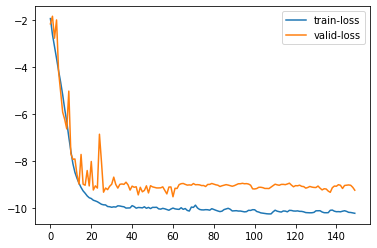

In [21]:
plt.plot(range(len(train_loss)),np.log(train_loss),label='train-loss')
plt.plot(range(len(train_loss)),valid_loss,label='valid-loss')
plt.legend()

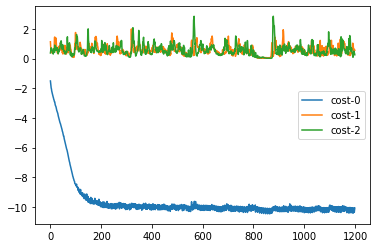

In [46]:
plt.plot(range((costs.shape[0])),np.log(costs[:,0]),label='cost-0')
plt.plot(range((costs.shape[0])),costs[:,1],label='cost-1')
plt.plot(range((costs.shape[0])),costs[:,2],label='cost-2')
plt.legend()

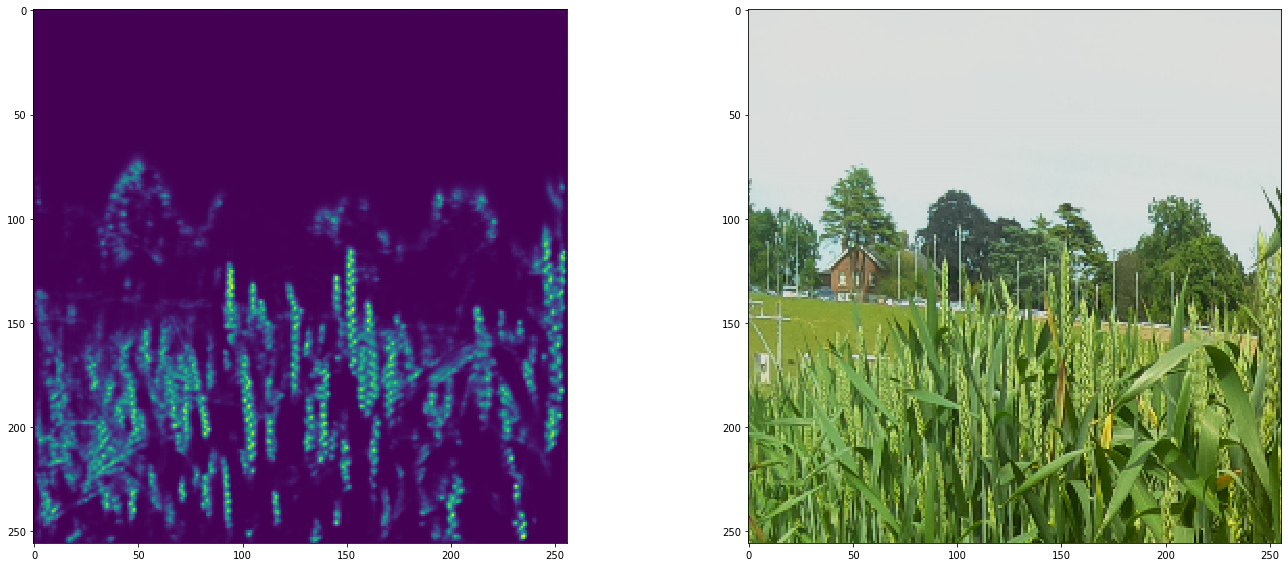

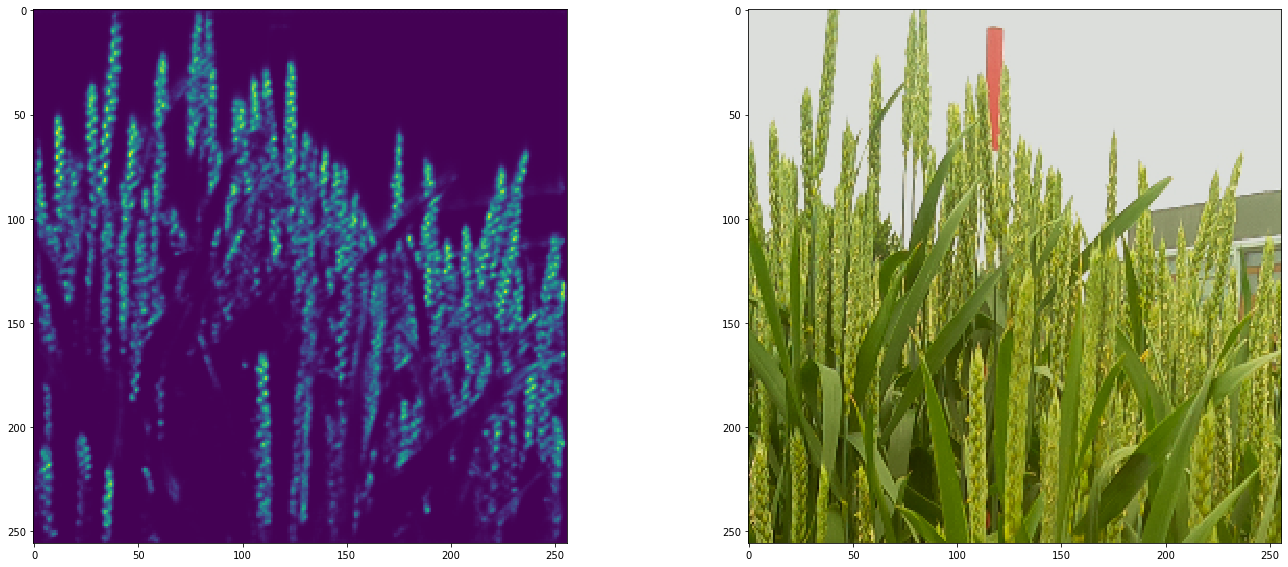

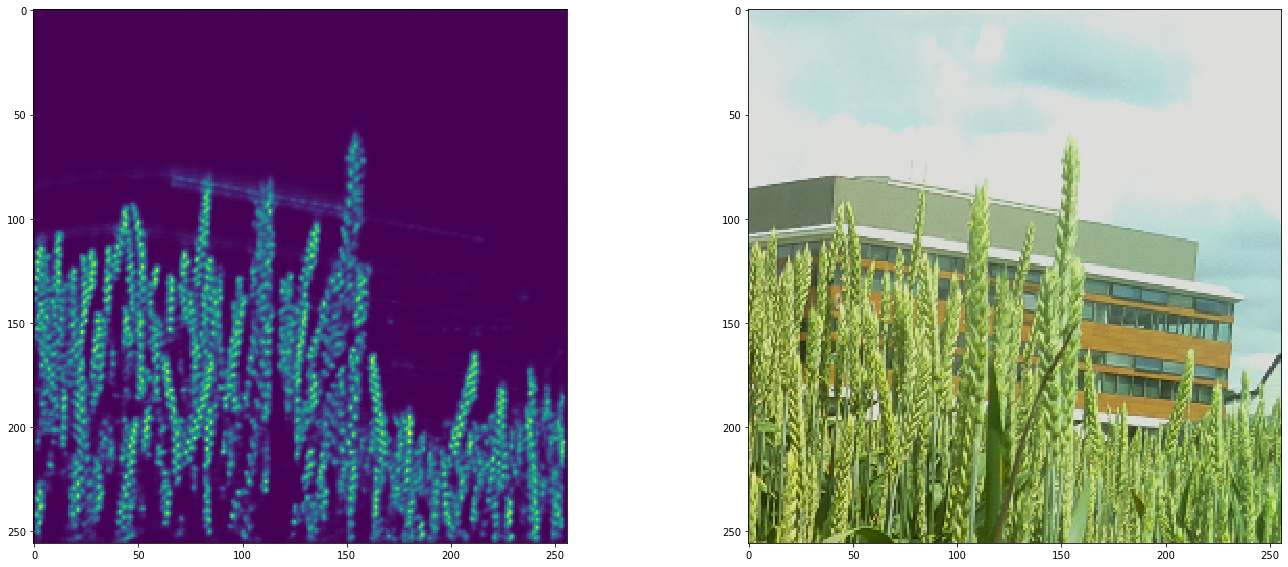

In [44]:
t = 0

for x,y,z in train_target_ds_loader:
    spikelet_cnn.eval()
    
    with torch.no_grad():
        x,y = x.to(device),y
        index = 15
        
        pred,_= spikelet_cnn(x)
       
        plt.subplots(1,2,figsize=(20,8))
        plt.tight_layout()
            
        plt.subplot(1,2,1)
        plt.imshow(pred.cpu().detach().numpy()[index,0,:,:])


        plt.subplot(1,2,2)
        plt.imshow(x[index,:,:,:].permute(1,2,0).cpu().detach().numpy())

        plt.show()
    if t == 2:
        break
    t+=1

In [29]:
# torch.save(spikelet_cnn.state_dict(),'acid_adapted_cq_2016_00.pth')